# Agrotech 2022 Project
We took the moisture readings from each plant for one day and plotted it together with the Zev's group VPD measurements

In [1]:
#Import packages
import urllib
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
import matplotlib.dates as mdates
import datetime as dt
import matplotlib as mpl
from pandas.tseries.frequencies import to_offset
from scipy.signal import savgol_filter

mpl.rcParams.update({'font.size': 16})

CSV files configuration

In [2]:
filename = "feeds.csv"
filename_other = "feeds_other.csv"

Extrating the fields from the csv files into pandas DataFrame objects for the desired time

In [3]:
df = pd.read_csv(filename)
# rename columns
df = df.rename(columns={"created_at": "timestamp",
                        "field1": "Soil Moisture-Tomato plant",
                        "field2": "Soil Moisture-Pepper 1 plant",
                        "field3": "Soil Moisture-Corn plant",
                        "field4": "Soil Moisture-Pepper 2 plant",})

df_other = pd.read_csv(filename_other)
df_other = df_other.rename(columns={"created_at": "timestamp",
                        "field1": "Temerature",
                        "field2": "Relative Humidity",
                        "field3": "Barometric Pressure",
                        "field4": "Elevation",
                        "field5": "Windspeed",
                        "field6": "VPD"})

df_other['timestamp'] = pd.to_datetime(df_other['timestamp'])
df_other = df_other.set_index('timestamp')
df_other = df_other["2022-07-15"]



# Filter outliers (keep moisture >= 0)
for col in df.columns[2:6]:
  df = df[~(df[col].lt(0))]

# set timestamp as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

df_time = df["2022-07-15"]


df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


,entry_id,Soil Moisture-Tomato plant,Soil Moisture-Pepper 1 plant,Soil Moisture-Corn plant,Soil Moisture-Pepper 2 plant,latitude,longitude,elevation,status
timestamp,,,,,,,,,
2022-06-03 18:56:01+03:00,1,100.0,1.95895,50.53,NaN,NaN,NaN,NaN,NaN
2022-06-03 18:56:04+03:00,2,102.0,1.94697,50.69,NaN,NaN,NaN,NaN,NaN
2022-06-03 18:56:07+03:00,3,100.0,1.94319,50.70,NaN,NaN,NaN,NaN,NaN
2022-06-03 18:56:09+03:00,4,92.0,1.93701,50.80,NaN,NaN,NaN,NaN,NaN
2022-06-03 18:56:12+03:00,5,100.0,1.93413,50.93,NaN,NaN,NaN,NaN,NaN


Plotting the moisture measurements for each plant, together with the VPD

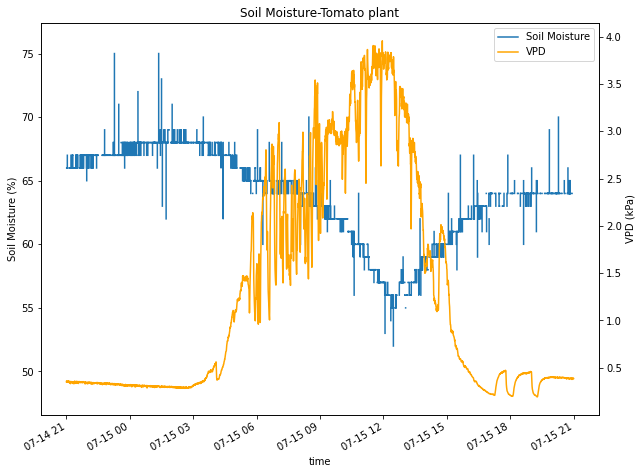

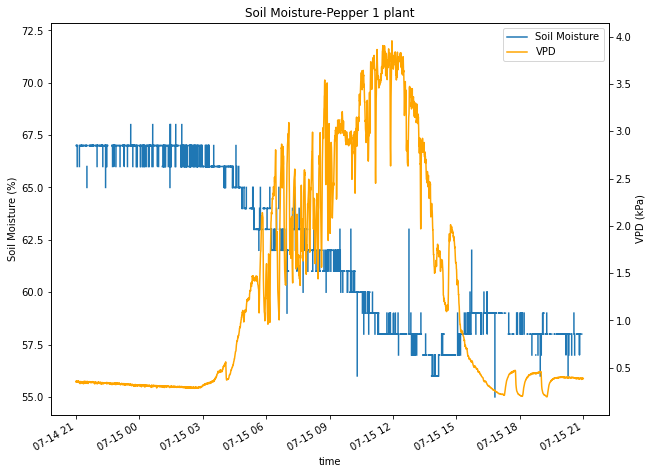

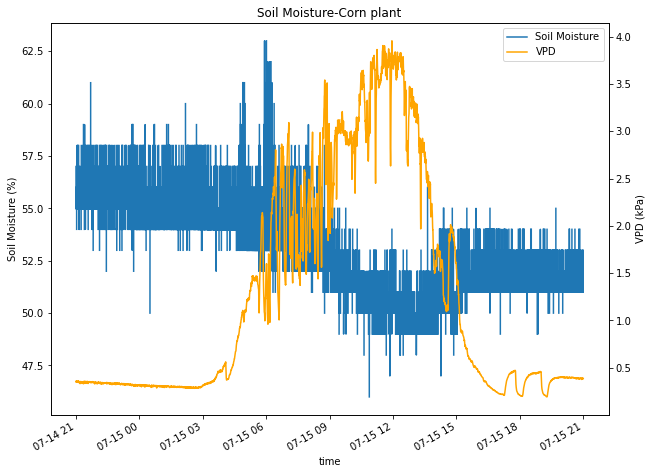

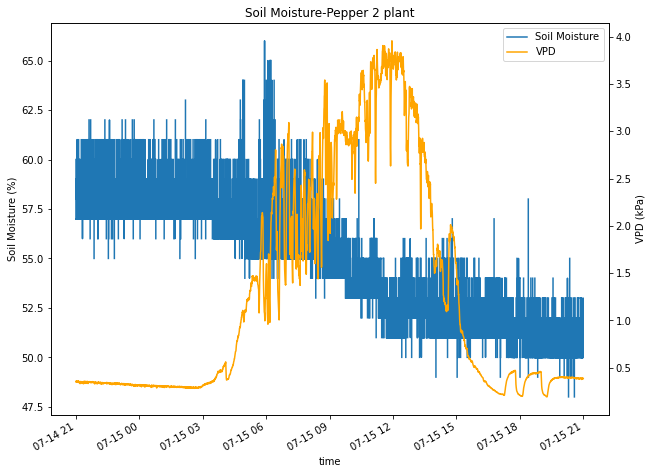

In [20]:
for col in df.columns[1:5]:
  for df in [df_time]:
    fig, ax = plt.subplots(1, figsize=(10,8))

    p1 = ax.plot(df[col])
    # add labels and title
    ax.set(xlabel = "time",
          ylabel = "Soil Moisture (%)",
          title = col)

    ax2 = ax.twinx()
    p2 = ax2.plot(df_other["VPD"], color='orange')
    ax2.set_ylabel('VPD (kPa)')
    plt.legend(p1 + p2, ["Soil Moisture", "VPD"])

    # makes slanted dates
    plt.gcf().autofmt_xdate()


We saw a lot of noise in the above plots and wanted to try and smooth the moisture plot

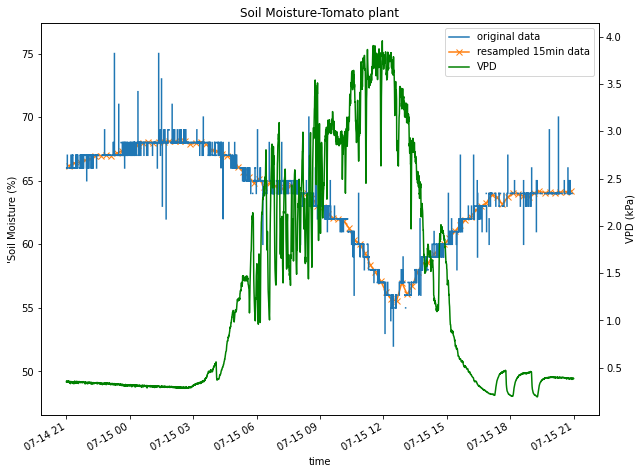

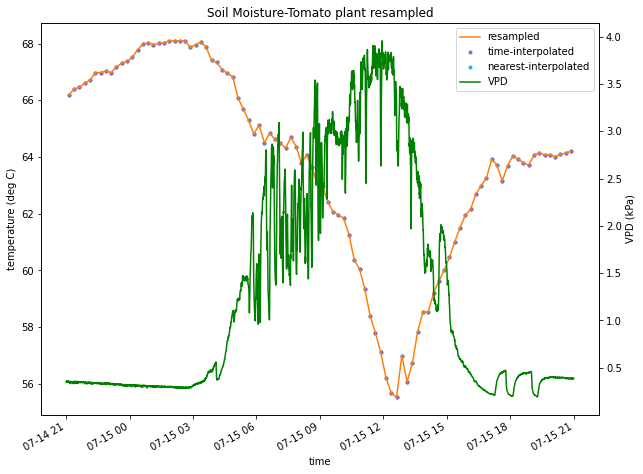

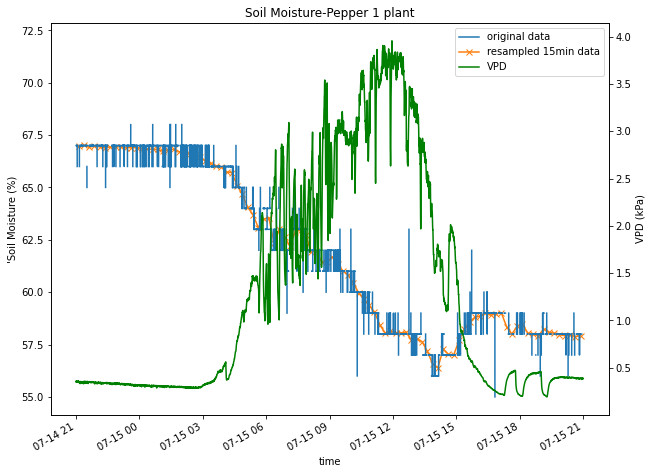

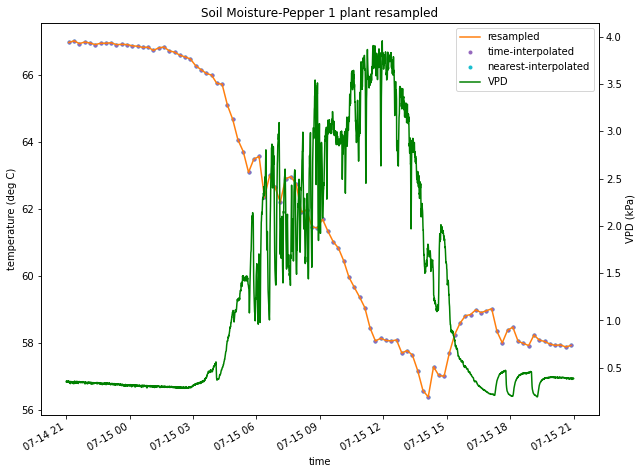

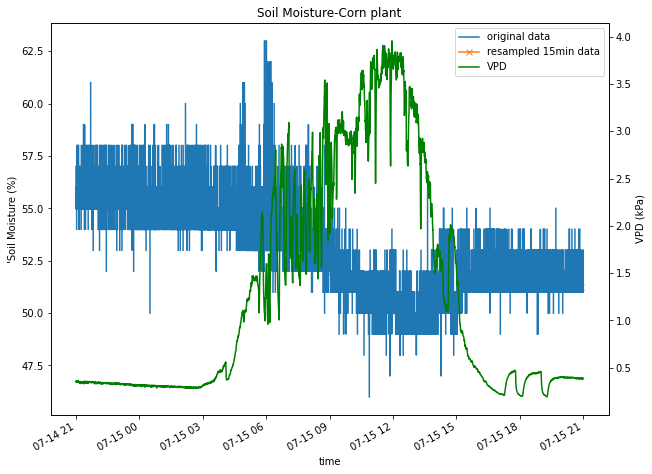

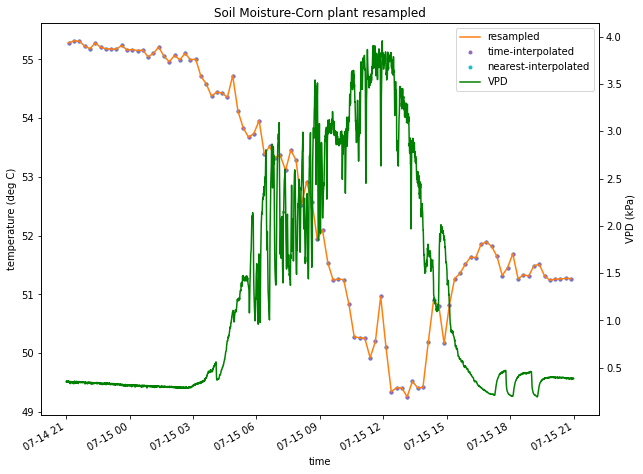

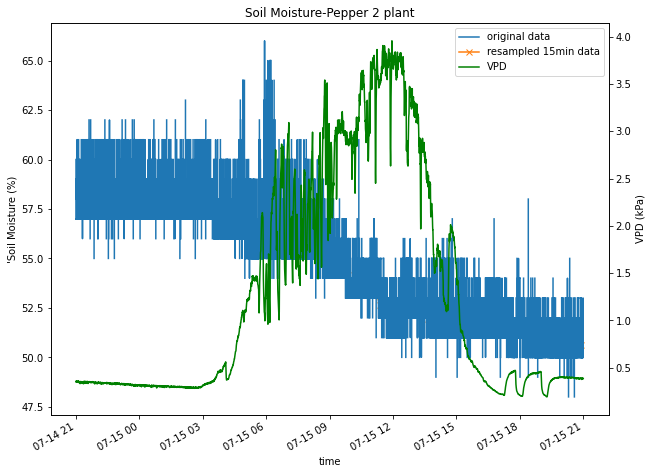

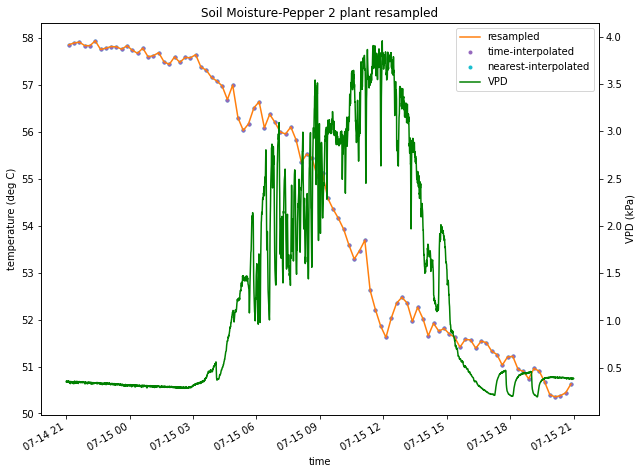

In [24]:
for col in df.columns[1:5]:
  for df in [df_time]:
    fig, ax = plt.subplots(1, figsize=(10,8))

    # Downsample to spaced out data points. Change the number below, see what happens.
    window_size = '15min'
    df_resampled = (df[col].resample(window_size)  # resample doesn't do anything yet, just divides data into buckets
                            .mean()                 # this is where stuff happens. you can also choose "sum", "max", etc
                  )
    # optional, add half a window size to timestamp
    df_resampled.index = df_resampled.index + to_offset(window_size) / 2

    p1= ax.plot(df[col], color="tab:blue", label="original data")
    p2 = ax.plot(df_resampled, marker='x', color="tab:orange", zorder=-1,
            label=f"resampled {window_size} data")

    ax.set(xlabel="time",
          ylabel="'Soil Moisture (%)", title=col)
    
    ax2 = ax.twinx()
    p3 = ax2.plot(df_other["VPD"], color='green')
    ax2.set_ylabel('VPD (kPa)')
    plt.legend(p1 + p2 + p3, ["original data", f"resampled {window_size} data", "VPD"])


    fig.autofmt_xdate()
    
    fig, ax = plt.subplots(1, figsize=(10,8))

    # see options for interpolation methods here:
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
    df_interpolated1 = df_resampled.interpolate(method='time')
    df_interpolated2 = df_resampled.interpolate(method='nearest')

    p1 = ax.plot(df_resampled, color="tab:orange", label="resampled")
    p2 = ax.plot(df_interpolated1, '.', color="tab:purple", zorder=-1,
            label=f"time-interpolated")
    p3 = ax.plot(df_interpolated2, '.', color="tab:cyan", zorder=-2,
            label=f"nearest-interpolated")

    ax.set(xlabel="time",
          ylabel="temperature (deg C)", title=col + " resampled")
    
    ax2 = ax.twinx()
    p4 = ax2.plot(df_other["VPD"], color='green')
    ax2.set_ylabel('VPD (kPa)')
    plt.legend(p1 + p2 + p3 + p4, ["resampled", "time-interpolated", "nearest-interpolated", "VPD"])

    
    fig.autofmt_xdate()

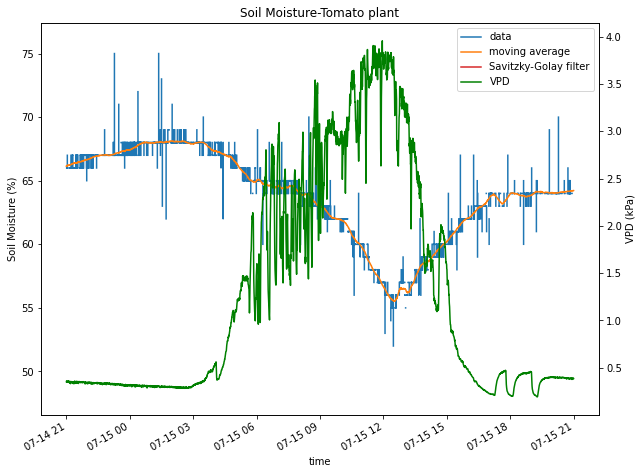

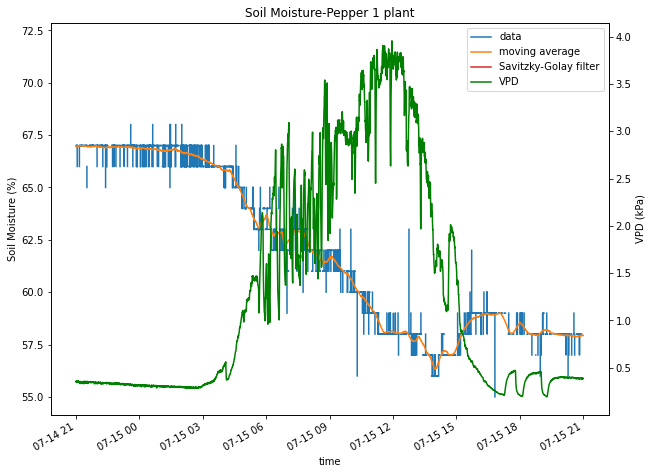

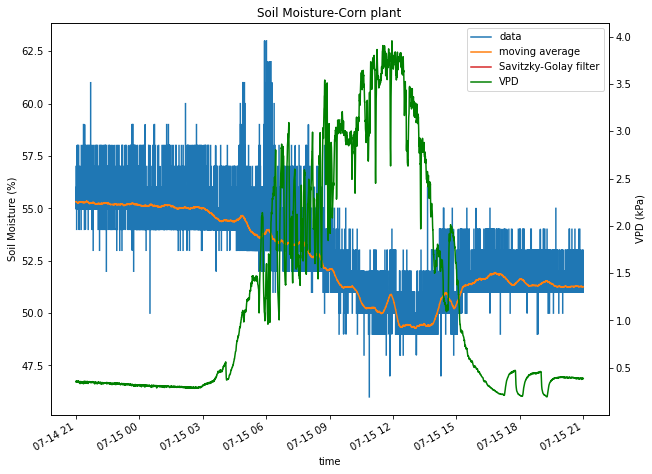

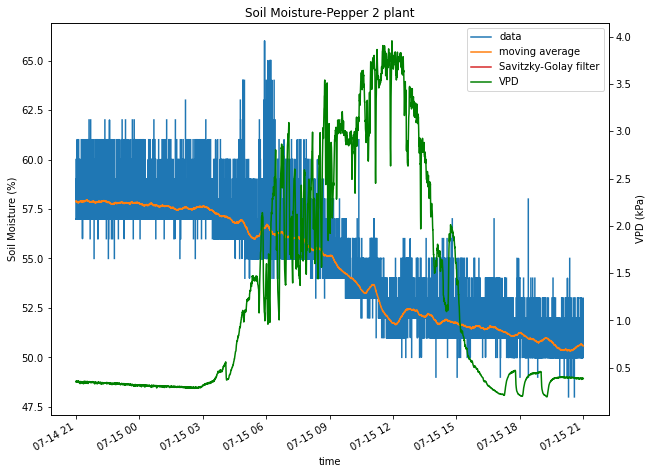

In [25]:
for col in df.columns[1:5]:
  for df in [df_time]:
    fig, ax = plt.subplots(1, figsize=(10,8))

    # apply a rolling average of size "window_size",
    # it can be either by number of points, or by window time
    #window_size = 6000  # number of measurements
    window_size = '24min'  # minutes
    RH_smooth = df[col].rolling(window_size, center=True).mean().to_frame()
    RH_smooth.rename(columns={col: 'rolling_avg'}, inplace=True)

    RH_smooth['SG'] = savgol_filter(df[col], window_length=121, polyorder=2)

    p1 = ax.plot(df[col], color="tab:blue", label="data")
    p2 = ax.plot(RH_smooth['rolling_avg'], color="tab:orange", label="moving average")
    p3 = ax.plot(RH_smooth['SG'], color="tab:red", label="Savitzky-Golay filter")
    # add labels and title
    ax.set(xlabel = "time",
          ylabel = "Soil Moisture (%)",
          title = col)
    # makes slanted dates
    plt.gcf().autofmt_xdate()

    ax2 = ax.twinx()
    p4 = ax2.plot(df_other["VPD"], color='green')
    ax2.set_ylabel('VPD (kPa)')
    plt.legend(p1 + p2 + p3 + p4, ["data", "moving average", "Savitzky-Golay filter", "VPD"])
    